# The data is collected from - [here](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names)

The data is a set of vaiables, and the income level (<= 50K or >50K) for a set of US citizen, depending on the variables. To know more about the sampling technique and the nature of few parameters please check the URL. I am also adding the followig note (copy-pasted from the link) for quick reference.

>  Description of fnlwgt (final weight)The weights on the CPS files are controlled to independent estimates of the civilian noninstitutional population of the US.  These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls.

>   These are:
>   
>   1.  A single cell estimate of the population 16+ for each state.
>   
>   2.  Controls for Hispanic Origin by age and sex.
>   
>   3.  Controls by Race, age and sex.
   

>We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used.

>The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population.

>People with similar demographic characteristics should have similar weights.There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.



We first import all the necessary libarries

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
from PIL import Image


from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import TensorBoard
from keras import optimizers
from keras import regularizers

%matplotlib inline

Using TensorFlow backend.


We define some functions that we are going to use to prepare our data. Make a note there is absolutely no 
feature engineering going on here apart from numeratizing some text values.

In [20]:
def strip_it(s):
    if isinstance(s, str):
        return s.strip()
    else:
        return ''

    
def load_initial_data(file_name):
    names = ["age", "workclass", "finalweight", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]
    df = pd.read_csv(file_name, index_col=False, header=None, names=names)
    return df
    
    
def prepare_data(df, income_str="<=50K"):
    """To prepare our training and test sets.
    
        df (DataFrame): A pandas data frame
        income_str(str): A string representing the value to be expected in the income column.
    """
    # bcause we need to assign 1 to > 50k
    df['income'] = np.where(df.income.str.strip() == income_str, "0", "1")
    
    # Converting training data
    df['workclass'].replace(' ?', np.nan, inplace=True)
    df['native-country'].replace(' ?', np.nan, inplace=True)
    df['education'].replace(' ?', np.nan, inplace=True)
    df['occupation'].replace(' ?', '', inplace=True)
    df['relationship'].replace(' ?', '', inplace=True)
    df['native-country'].replace(' ?', '', inplace=True)

    workclass_rep = {'State-gov': 1, 'Self-emp-not-inc': 2, 'Private': 3, 'Federal-gov': 4,
           'Local-gov': 5, 'Self-emp-inc': 6, 'Without-pay': 7, 'Never-worked': 8}

    df['workclass_num'] = pd.Series(df['workclass'].apply(lambda x: workclass_rep[x.strip()] if x is not np.nan else np.nan))
    # education_rep = {'Bachelors': 1, 'HS-grad': 2, '11th': 3, 'Masters': 4, '9th': 5,
    #         'Some-college': 6, 'Assoc-acdm': 7, 'Assoc-voc': 8, '7th-8th': 9,
    #         'Doctorate': 10, 'Prof-school': 11, '5th-6th': 12, '10th': 13, '1st-4th': 14,
    #         'Preschool': 15, '12th': 16}
    # df['education_num'] = df['education'].apply(lambda x: education_rep[x.strip()] if x is not np.nan else np.nan)

    marital_rep = {'Never-married': 1, 'Married-civ-spouse': 2, 'Divorced': 3,
           'Married-spouse-absent': 5, 'Separated': 6, 'Married-AF-spouse': 7,
            'Widowed': 8}
    df['marital_status_num'] = df['marital-status'].apply(lambda x: marital_rep[x.strip()] if x is not np.nan else np.nan)

    df.dropna(subset=['workclass', 'native-country', 'education'])

    oc = map(strip_it, df['occupation'].unique())
    occ = {o: idx+1 for idx, o in enumerate(oc) if o}
    df['occupation_num'] = pd.Series(df['occupation'].apply(lambda x: occ[x.strip()] if isinstance(x, str) and x.strip() in occ else np.nan))

    oc = map(strip_it, df['relationship'].unique())
    occ = {o: idx+1 for idx, o in enumerate(oc) if o}
    df['relationship_num'] = pd.Series(df['relationship'].apply(lambda x: occ[x.strip()] if isinstance(x, str) and x.strip() in occ else np.nan))

    oc = map(strip_it, df['native-country'].unique())
    occ = {o: idx+1 for idx, o in enumerate(oc) if o}
    df['native-country_num'] = pd.Series(df['native-country'].apply(lambda x: occ[x.strip()] if isinstance(x, str) and x.strip() in occ else np.nan))

    df1 = df[['age', 'education-num', 'finalweight', 'hours-per-week', 'workclass_num', 'marital_status_num', 'occupation_num', 'native-country_num', 'capital-gain', 'capital-loss', 'income']]
    df2 = df1.dropna()
    
    df2.apply(pd.to_numeric, errors='ignore')
    Xtemp = df2[['age', 'education-num', 'finalweight', 'hours-per-week', 'workclass_num', 'marital_status_num', 'occupation_num', 'native-country_num', 'capital-gain', 'capital-loss']]
    Xtemp['avg_finalweight'] = Xtemp.apply(lambda row: row['finalweight'] / Xtemp.shape[0], axis=1)
    Xtemp.drop('finalweight', axis=1, inplace=True)
    y = df2['income']

    return Xtemp, y


def normalize(xval):
    """To normalize the data
    """
    min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    X = min_max_scaler.fit_transform(xval)
    scaler = preprocessing.StandardScaler().fit(X)
    X = scaler.transform(X)
    X = X.astype('float32')
    return X

We load the data now.

In [21]:
xtemp_df1 = load_initial_data('adult.data')
xtemp_df2 = load_initial_data('adult.test')

How do the initial data looks like?

In [22]:
xtemp_df1.head()

,age,workclass,finalweight,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,>50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Now we prepare the initial data

In [23]:
xtemp1, y1 = prepare_data(xtemp_df1)
xtemp2, y2 = prepare_data(xtemp_df2, income_str="<=50K.")

How do the processed data look like?

In [24]:
xtemp1.head()

,age,education-num,hours-per-week,workclass_num,marital_status_num,occupation_num,native-country_num,capital-gain,capital-loss,avg_finalweight
0,39,13,40,1.0,1,1.0,1.0,2174,0,2.569989
1,50,13,13,2.0,2,2.0,1.0,0,0,2.762118
2,38,9,40,3.0,3,3.0,1.0,0,0,7.149592
3,53,7,40,3.0,2,3.0,1.0,0,0,7.782010
4,28,13,40,3.0,2,4.0,2.0,0,0,11.219714


A little bit of statistics ...

In [25]:
xtemp1.describe()

,age,education-num,hours-per-week,workclass_num,marital_status_num,occupation_num,native-country_num,capital-gain,capital-loss,avg_finalweight
count,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000
mean,38.437902,10.121312,40.931238,3.109343,2.146575,5.287879,2.245839,1092.007858,88.372489,6.292482
std,13.134665,2.549995,11.979984,0.934785,1.433089,3.102449,5.100457,7406.346497,404.298370,3.502850
min,17.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.456502
25%,28.000000,9.000000,40.000000,3.000000,1.000000,2.000000,1.000000,0.000000,0.000000,3.899849
50%,37.000000,10.000000,40.000000,3.000000,2.000000,5.000000,1.000000,0.000000,0.000000,5.915556
75%,47.000000,13.000000,45.000000,3.000000,2.000000,7.000000,1.000000,0.000000,0.000000,7.878407
max,90.000000,16.000000,99.000000,7.000000,8.000000,15.000000,42.000000,99999.000000,4356.000000,49.224355


A little bit of visual representation.

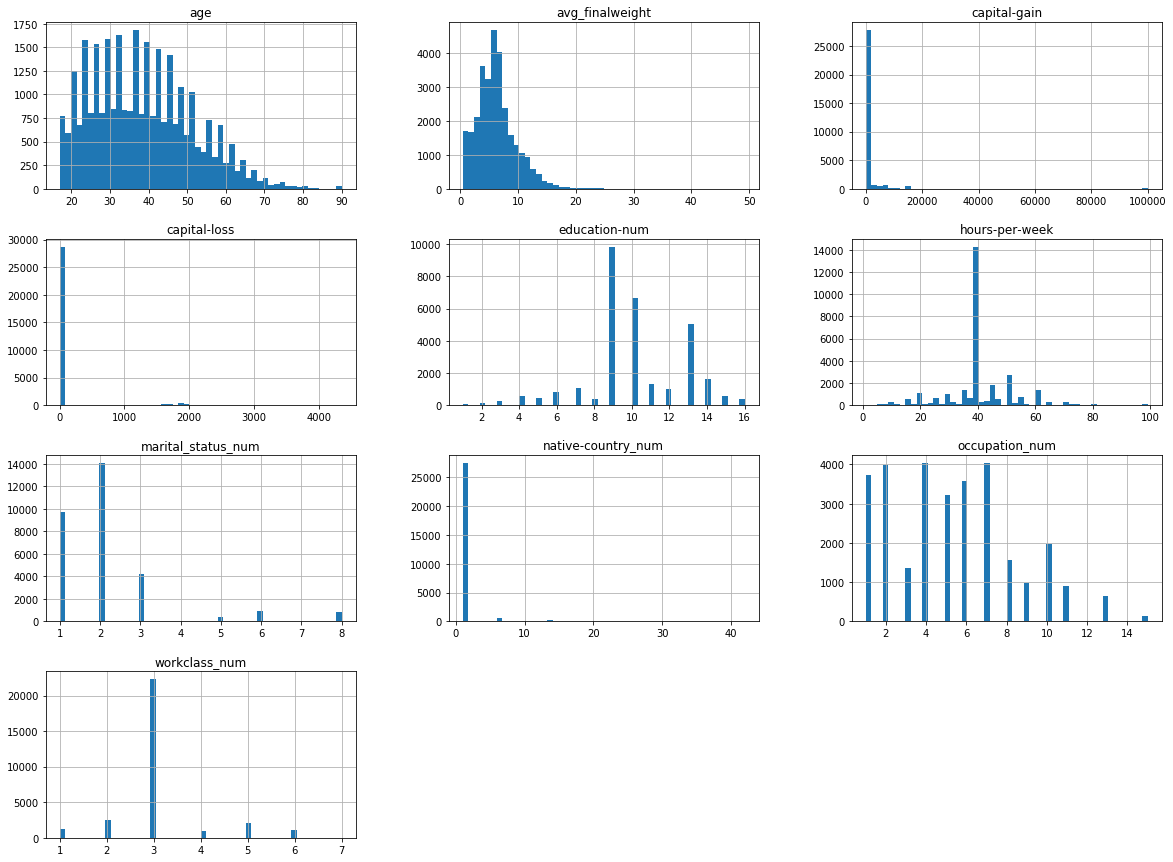

In [26]:
xtemp1.hist(bins=50, figsize=(20, 15))
plt.savefig('numeric_attributes.png')
plt.show()

Let's check the co-relation among the variables. (BUT remember, co-relation does not mean causation.)

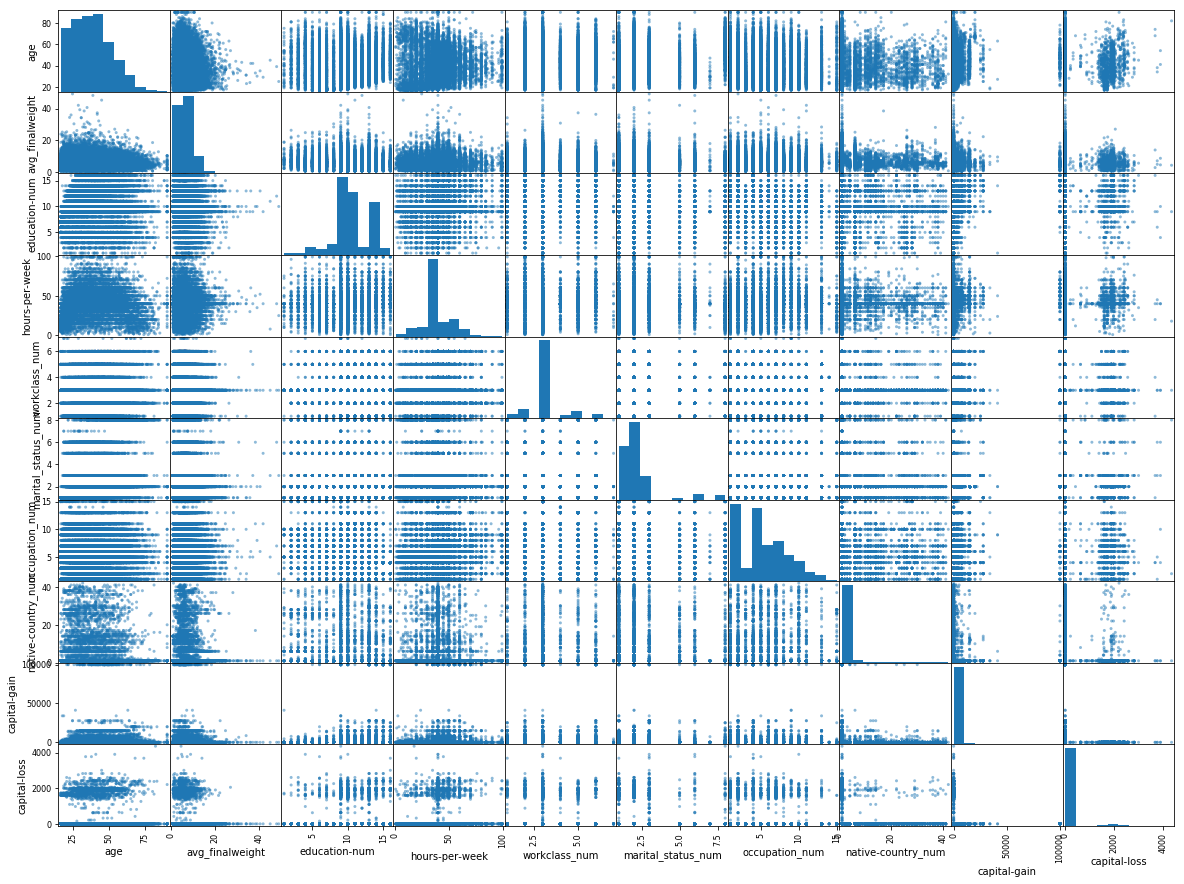

In [27]:
attributes = ['age', 'avg_finalweight', 'education-num', 'hours-per-week', 'workclass_num', 'marital_status_num', 'occupation_num', 'native-country_num', 'capital-gain', 'capital-loss']
scatter_matrix(xtemp1[attributes], figsize=(20, 15))
plt.savefig("scatter_matrix_plot.png")
plt.show()

How do the dimensions look like?

In [27]:
print(xtemp1.shape)
print(xtemp2.shape)

(30162, 10)
(15060, 10)


*The above numbers match the description of the dataset* 

It *also* tells us that we have a total of 30162 number of training examples each with 10 features and a total of 15060 number of test examples. 

it is time to normalize things.

In [28]:
X = normalize(xtemp1)
Y = y1.values.reshape(y1.shape[0], 1)

We assign the values to training sets. Just a convinient way to name variables for later use.

In [29]:
x_train = X
y_train = Y

As we will be using the test set to predict, we will normalize the data as well.

In [30]:
X = normalize(xtemp2)
Y = y2.values.reshape(y2.shape[0], 1)

And then, similarly, assign them to some variables with a nice name.

In [31]:
x_test = X
y_test = Y

## Time to build the Neural Net now!

In [32]:
# We need this to make a train-dev set split
from sklearn.model_selection import train_test_split
# Calculate the input dimension.
inpdim = x_train.shape[1]

# Create an optimizer
optim = optimizers.adam(lr=0.0001)

# This is not really used for now!
cvscores = []

# Build the network. 16->16->16->1 ... we are doing Deep Learning!
model = Sequential()
# The kernel_regularizer is the same as weight regularizer.
model.add(Dense(16, input_dim=inpdim, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(Dropout(0.7))  # Not for now. 
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
# model.add(Dropout(0.7))  #  Not for now
model.add(Dense(1, activation='sigmoid'))

# Compile our model to be reda
model.compile(loss='binary_crossentropy',
              optimizer=optim,
              metrics=['accuracy'])
# Train the model, iterating on the data in batches of 32 samples
x_train_splt, x_test_splt, y_train_splt, y_test_splt = train_test_split(x_train, y_train, test_size=0.1, random_state=0)

his = model.fit(x_train_splt, y_train_splt, epochs=100, batch_size=32)
scores = model.evaluate(x_test_splt, y_test_splt, verbose=0)
cvscores.append((scores[0], scores[1]))

Epoch 1/100
27145/27145 [==============================] - 1s - loss: 0.9585 - acc: 0.7515     
Epoch 2/100
27145/27145 [==============================] - 1s - loss: 0.7508 - acc: 0.7534     
Epoch 3/100
27145/27145 [==============================] - 1s - loss: 0.6429 - acc: 0.7719     
Epoch 4/100
27145/27145 [==============================] - 1s - loss: 0.5754 - acc: 0.7976     
Epoch 5/100
27145/27145 [==============================] - 1s - loss: 0.5325 - acc: 0.8071     
Epoch 6/100
27145/27145 [==============================] - 1s - loss: 0.5048 - acc: 0.8111     
Epoch 7/100
27145/27145 [==============================] - 1s - loss: 0.4866 - acc: 0.8141     
Epoch 8/100
27145/27145 [==============================] - 1s - loss: 0.4741 - acc: 0.8177     
Epoch 9/100
27145/27145 [==============================] - 1s - loss: 0.4651 - acc: 0.8195     
Epoch 10/100
27145/27145 [==============================] - 1s - loss: 0.4582 - acc: 0.8213     
Epoch 11/100
27145/27145 [=============

27145/27145 [==============================] - 1s - loss: 0.3786 - acc: 0.8445     
Epoch 86/100
27145/27145 [==============================] - 1s - loss: 0.3784 - acc: 0.8441     
Epoch 87/100
27145/27145 [==============================] - 2s - loss: 0.3784 - acc: 0.8441     
Epoch 88/100
27145/27145 [==============================] - 1s - loss: 0.3781 - acc: 0.8450     
Epoch 89/100
27145/27145 [==============================] - 1s - loss: 0.3778 - acc: 0.8443     
Epoch 90/100
27145/27145 [==============================] - 1s - loss: 0.3776 - acc: 0.8446     
Epoch 91/100
27145/27145 [==============================] - 1s - loss: 0.3775 - acc: 0.8438     
Epoch 92/100
27145/27145 [==============================] - 1s - loss: 0.3772 - acc: 0.8445     
Epoch 93/100
27145/27145 [==============================] - 1s - loss: 0.3772 - acc: 0.8448     
Epoch 94/100
27145/27145 [==============================] - 2s - loss: 0.3769 - acc: 0.8442     
Epoch 95/100
27145/27145 [=================

Let's plot the learning(accuracy) and error - 

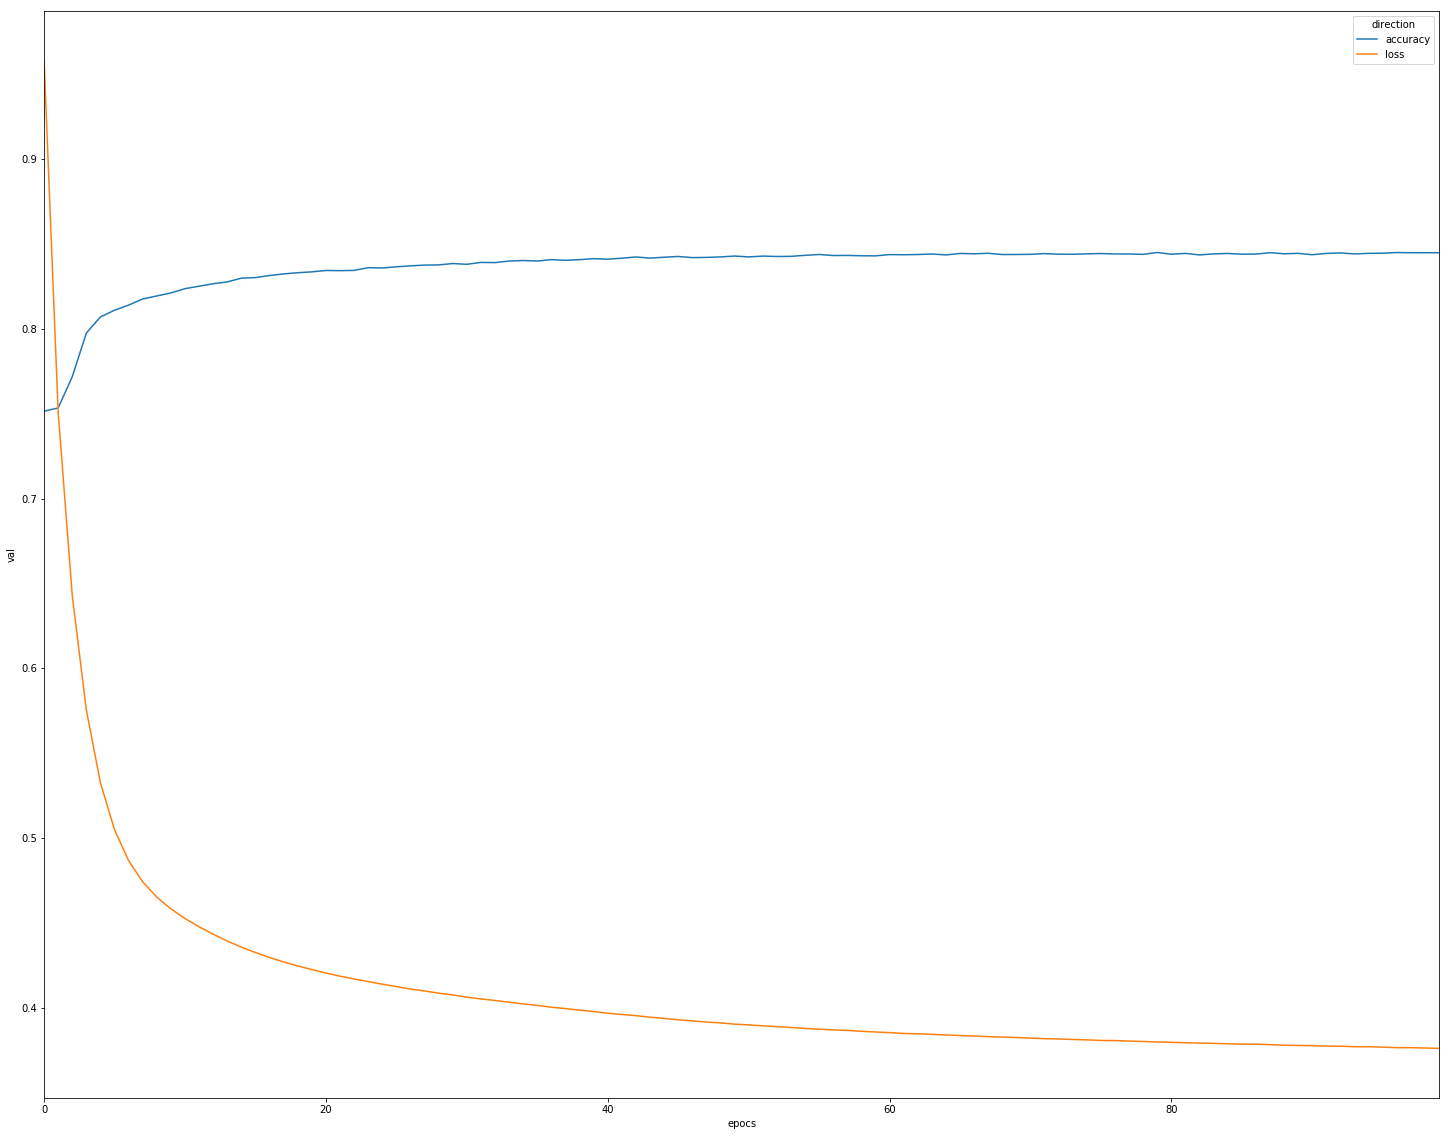

In [33]:
import warnings
warnings.filterwarnings('ignore')
epochs = [idx for idx, _ in enumerate(his.history['acc'])]
pf1 = pd.DataFrame({'epocs': epochs, 'val': his.history['acc'], 'direction':'accuracy'})
pf2 = pd.DataFrame({'epocs': epochs, 'val': his.history['loss'], 'direction':'loss'})
plot_frame = pd.concat([pf1,pf2],axis=0)
plot_frame['unit'] = 'subject'

fig = plt.figure(figsize=(25,20))
sns.tsplot(data=plot_frame, time='epocs', condition='direction',
unit='unit', value='val')

Looks nice! It seems that our model learned well. Let us try some predictions.

In [34]:
p = model.predict(x_test)
p_actual = np.where(p <= 0.5, 0, 1)
right_preds = []
for i in range(len(y_test)):
    yt = y_test[i]
    pt = p_actual[i]
    if yt.astype(int)==pt.astype(int):
        right_preds.append(1)

print("We predicted {} rightly among {} total".format(len(right_preds), y_test.shape[0]))
print("=============================================")
print("Which is - {}%".format((len(right_preds) / y_test.shape[0])*100))

We predicted 12668 rightly among 15060 total
Which is - 84.11686586985392%


This means, in the test set we have a (100-84.12) = 15.88% error. Not Bad! 